### Imports

In [2]:
import json
import re
import requests
import time
import os
from pathlib import Path
from requests.exceptions import RequestException

import numpy as np
import Levenshtein
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

from IPython.display import clear_output
from tqdm.auto import tqdm
# from tqdm.contrib.telegram import tqdm
tqdm.pandas()

dir_data = Path(r'C:\Users\rldek\Mijn Drive (r.l.dekkers@tilburguniversity.edu)\Thesis\Code\thesis-msc-data-science\data')

### Load data from saved progress

In [3]:
# ❗ TODO: change all filepaths to a OS-agnostic format
articles = pd.read_pickle(dir_data / 'articles.pkl')
gwsd = pd.read_pickle(dir_data / 'gwsd.pkl')

### Load data from scratch & pre-process

In [4]:
gwsd = pd.read_csv(dir_data / 'GWSD_url_enriched.csv')  # This file contains URL's of the source articles
gwsd = gwsd.dropna()   # File contains un-labeled samples which are not intended to be used

gwsd_orig = pd.read_csv(dir_data / 'GWSD.tsv', sep='\t', index_col=0)  # This file contains the sentences without unicode errors
gwsd_orig = gwsd_orig.dropna()  # File contains un-labeled samples which are not intended to be used

# Get correct sentence
gwsd['sentence'] = gwsd_orig['sentence']

# note label with highest probability score
label_cols = ['disagree', 'agree', 'neutral']
gwsd['label'] = gwsd[label_cols].apply(lambda x: label_cols[np.argmax(x.values)], axis=1)

# prepend 'https://' if not present
gwsd['url_key'] = gwsd['url_key'].apply(lambda url: 'https://' + url if not url.startswith(('https://', 'http://')) else url)

# manually clean mistakes in url's
gwsd.loc[1489, 'url_key'] = gwsd.loc[1489, 'url_key'].replace("#:~:text=Paleoclimatologists%20have%20established%20that%20Antarctica,have%20occurred%20in%20the%20past.", "")
gwsd.loc[1630, 'url_key'] = gwsd.loc[1630, 'url_key'].replace("#:~:text=Pieter%20Tans%20of%20the%20Earth,as%20well%20as%20ecological%20benefits.", "")

# extract domain of url (using regular expression)
# e.g. 'https://www.blog.nytimes.com/jan/2020 becomes 'blog.nytimes.com'
gwsd['domain'] = gwsd['url_key'].apply(lambda url: re.sub(r"(http(s)?)?://(www.)?", "", url).split('/')[0])

# save to pickle for easy loading
gwsd.to_pickle(dir_data / 'gwsd.pkl')

### Get HTML

##### Load or create file

In [58]:
# Load if exists
filename = dir_data / 'articles.pkl'
if filename.exists():
    articles = pd.read_pickle(filename)
else: # Otherwise, create file
    # Create DataFrame
    articles = gwsd[['url_key', 'label', 'sentence', 'worker_0', 'worker_1', 'worker_2', 'worker_3', 'worker_4', 'worker_5', 'worker_6', 'worker_7', 'disagree', 'agree', 'neutral', 'in_held_out_test']]
    articles['html'] = ''
    articles['status'] = ''

    # Save DataFrame
    # articles.to_pickle(filename)

##### Get HTML for all url's

In [120]:
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36"}

def print_progress(i: int, status: str) -> None:
    """Print progress of fetching HTML's"""
    clear_output(wait=True)
    print(f"🔎 Just completed index {i} with status '{status}'\n")
    print(articles['status'].value_counts())

def get_html(url: str) -> tuple[str, str]:
    """For url, return HTML (str) and HTTP status code (str)"""
    try:
        response = requests.get(url, headers=headers)
        status = str(response.status_code)
        if status == '200':
            return (response.text, status) 
        else:
            return ('', status)
    except RequestException as e:
        return ('', type(e).__name__)

def get_url_json_archive(url:str) -> str:
    """For target url, return url of archive JSON list (str)"""
    return 'http://web.archive.org/cdx/search/cdx?url=' + url + '&output=json'

# Note that i starts from 1! (JSON item 0 is the header)
def get_url_i_from_archive_json(i: int, url_target: str) -> str:
    """For target url, return url number i (starting from 1) in JSON list of archive entries"""
    url = get_url_json_archive(url_target)

    try:
        response = requests.get(url, headers=headers)
        if response != 200:
            return ''
    except RequestException as e:
        return ''
    
    # if returned JSON is empty (url is not found in archive)
    if not json.loads(response.text):
        return ''

    entry_i = json.loads(response.text)[i]
    return 'https://web.archive.org/web/' + entry_i[1] + '/' + entry_i[2]

def get_html_from_archive(url_target: str) -> tuple[str, str]:

    url = get_url_json_archive(url_target)

    text_json, status = get_html(url)
    if status != '200':
        return ('', status + ' (archive)')

    # if empty json (not found in archive)
    if not json.loads(text_json):
        return ('', 'missing')

    # Find earliest valid archive entry
    json_list = json.loads(text_json)
    first_valid_entry = None
    for entry in json_list:
        if entry[4] == '200': # the 5th column contains the status
            first_valid_entry = entry
            break
    if not first_valid_entry:
        return ('', 'missing')
    
    # construct archive entry url from JSON
    archive_url = 'https://web.archive.org/web/' + first_valid_entry[1] + '/' + first_valid_entry[2]
    text, status = get_html(archive_url)
    return (text, status + ' (archive)')

In [35]:
counter = 0

for i in articles.index:

    # skip completed articles and definitely missing articles
    if articles.loc[i, 'html'] != '' or articles.loc[i, 'status'] == 'missing':
        continue

    # if article not yet attempted
    if articles.loc[i, 'status'] == '':
        articles.loc[i, 'html'], articles.loc[i, 'status'] = get_html(articles.loc[i, 'url_key'])

    # if obtaining html failed
    if articles.loc[i, 'status'] != '200' and articles.loc[i, 'status'] != '':
        articles.loc[i, 'html'], articles.loc[i, 'status'] = get_html_from_archive(articles.loc[i, 'url_key'])

    # regularly save DF to pickle
    # if counter % 10 == 0:
    #     articles.to_pickle(dir_data / 'articles.pkl')

    # Wait to prevent making too many requests
    time.sleep(2) 

    print_progress(i, articles.loc[i, 'status'])

🔎 Just completed index 1686 with status '200'

status
200              1752
200 (archive)     296
missing             2
Name: count, dtype: int64


### Text extraction

In [148]:
""" Notes

motherjones.com               458 ✅ Text obtained per paragraph. 
breitbart.com                 290 ✅ Text obtained per paragraph.
nytimes.com                   283 ✅ Text obtained per paragraph, ⚠️ except 17 missing
dotearth.blogs.nytimes.com    262 ✅ Text obtained per paragraph.
csmonitor.com                 257 ✅ Text obtained per paragraph.
foxnews.com                   132 ✅ Text obtained per paragraph. 
green.blogs.nytimes.com       103 ✅ Text obtained per paragraph.
theblaze.com                   90 ✅ Text obtained per paragraph.
buzzfeednews.com               58 ✅ Text obtained per paragraph.
progressive.org                39 ✅ Text obtained per paragraph.
democracynow.org               26 ✅ Text obtained per paragraph.
buzzfeed.com                   23 ✅ Text obtained per paragraph.
pjmedia.com                    14 ✅ Text obtained per paragraph.
nationalreview.com              8 ⚠️ All HTML documents unusable and inconsistent with webbrowser. The content seems to be contained in JS? 
archive.nytimes.com             5 ✅ Text obtained per paragraph.
thehill.com                     1 ✅ Text obtained per paragraph.
nonprofitquarterly.org          1 ✅ Text obtained per paragraph.

"""

def extract_body(html: str, domain: str, status: str) -> list:
    """Extract article body as list of paragraphs from HTML. The method depends on the domain and whether the article was retrieved from the archive."""

    if status == 'missing':
        return []
    
    soup = BeautifulSoup(html, "html.parser")

    if domain == 'motherjones.com':
        art = soup.find("article")
        tags = art.find_all(lambda tag: tag.name == "p" and not tag.get("class") and not tag.find("figure"))
        return [tag.text for tag in tags]
    elif domain == 'breitbart.com':
        art = soup.find(lambda tag: tag.name=="div" and tag.get("class")==["entry-content"])
        tags = art.find_all(["p", "h2"])
        return [tag.text for tag in tags]
    elif domain == 'nytimes.com':
        art = soup.find(lambda tag: tag.name=="article" and tag.get("id") and "story" in tag.get("id"))
        if art:
            tags = art.find_all("p")
            return [tag.text for tag in tags]
        else:
            return []
    elif domain == 'dotearth.blogs.nytimes.com' or domain == 'green.blogs.nytimes.com' or domain == 'archive.nytimes.com':
        art = soup.find(lambda tag: tag.name=="article" and tag.get("class"))
        tags = art.find_all("p")
        return [tag.text for tag in tags]
    elif domain == 'csmonitor.com':
        art = soup.find(lambda tag: tag.name == "div" and tag.get("class") and "story-two" in tag.get("class"))
        tags = art.find_all("p")
        return [art.text for art in tags]
    elif domain == 'foxnews.com':
        art = soup.find(lambda tag: tag.name=="div" and tag.get("class") and "article-body" in tag.get("class"))
        tags = art.find_all("p")
        return [tag.text for tag in tags]
    elif domain == 'theblaze.com':
        if status == '200 (archive)':
            art = soup.find(lambda tag: tag.name == "div" and tag.get("class") and "entry-content" in tag.get("class"))
            tags = art.find_all("p")
            return [art.text for art in tags]
        else:        
            art = soup.find(lambda tag: tag.name == "div" and tag.get("class") and "body" in tag.get("class"))
            tags = art.find_all("p")
            return [art.text for art in tags]
    elif domain == 'buzzfeednews.com' or domain == 'buzzfeed.com':
        art = soup.find(lambda tag: tag.name=="article")
        tags = art.find_all("p")
        return [tag.text for tag in tags]
    elif domain == 'progressive.org':
        art = soup.find(lambda tag: tag.name=="div" and tag.get("class") and "content" in tag.get("class"))
        tags = art.find_all("p")
        return [tag.text for tag in tags]
    elif domain == 'democracynow.org':
        soup = BeautifulSoup(html)
        art = soup.find(lambda tag: tag.name=="div" and tag.get("id") and "story_text" in tag.get("id"))
        tags = art.find_all("p")
        return [tag.text for tag in tags]
    elif domain == 'pjmedia.com':
        if status == '200 (archive)':
            art = soup.find(lambda tag: tag.name=="div" and tag.get("class") and "pages" in tag.get("class"))
            tags = art.find_all("p")
            return [tag.text for tag in tags]
        else:
            art = soup.find(lambda tag: tag.name=="section" and tag.get("class")==["post-body"])
            tags = art.find_all("p")
            return [tag.text for tag in tags]
    elif domain == 'nationalreview.com':
        return [] 
    elif domain == 'thehill.com':
        art = soup.find(lambda tag: tag.name=="div" and tag.get("class") and "article__text" in tag.get("class"))
        tags = art.find_all("p")
        return [tag.text for tag in tags]
    elif domain == 'nonprofitquarterly.org':
        art = soup.find(lambda tag: tag.name=="div" and tag.get("class") and "entry-content" in tag.get("class"))
        tags = art.find_all("p")
        return [tag.text for tag in tags]
    else:
        return []

def extract_title(html: str, domain: str, status: str) -> str:
    """Extract article title from HTML. The method depends on the domain and whether the article was retrieved from the archive."""
    if status == 'missing':
        return ''
    
    soup = BeautifulSoup(html, "html.parser")

    if domain == 'motherjones.com':
        return soup.find(lambda tag: tag.name=="h1").text
    elif domain == 'breitbart.com':
        return soup.find(lambda tag: tag.name=="h1").text
    elif domain == 'nytimes.com':
        title = soup.find(lambda tag: tag.name=="h1")
        if title:
            return title.text
        else:
            return ''
    elif domain == 'dotearth.blogs.nytimes.com' or domain == 'green.blogs.nytimes.com' or domain == 'archive.nytimes.com':
        return soup.find(lambda tag: tag.name=="h1").text
    elif domain == 'csmonitor.com':
        return soup.find(lambda tag: tag.name=="h1").text
    elif domain == 'foxnews.com':
        return soup.find(lambda tag: tag.name=="h1").text
    elif domain == 'theblaze.com':
        return soup.find(lambda tag: tag.name=="h1").text
    elif domain == 'buzzfeednews.com' or domain == 'buzzfeed.com':
        return soup.find(lambda tag: tag.name=="h1").text
    elif domain == 'progressive.org':
        return soup.find(lambda tag: tag.name=="h1").text
    elif domain == 'democracynow.org':
        art = soup.find(lambda tag: tag.name=="div" and tag.get("id") and "story_content" in tag.get("id"))
        return art.find(lambda tag: tag.name=="h1").text
    elif domain == 'pjmedia.com':
        return soup.find(lambda tag: tag.name=="h3").text
    elif domain == 'nationalreview.com':  
        return ''  # ⚠️
    elif domain == 'thehill.com':
        return soup.find(lambda tag: tag.name=="h1").text
    elif domain == 'nonprofitquarterly.org':
        return soup.find(lambda tag: tag.name=="h1").text
    else:
        return ''

##### Body extraction

In [149]:
# Extract article bodies
articles['body'] = articles.progress_apply(lambda row: extract_body(row['html'], row['domain'], row['status']), axis=1)

# Identify failed samples
idx_no_body = articles[articles['body'].apply(lambda row: row == [])].index
print(f"Article bodies extracted. {len(idx_no_body)} are missing: ")
articles.loc[idx_no_body]

  0%|          | 0/2050 [00:00<?, ?it/s]

Article bodies extracted. 27 are missing: 


,url_key,label,html,status,domain,body,title,body_sents,sentence,worker_0,...,sent+5,sent0,idx_sent_in_body_sents,range_span_in_sent,extr_sentence,extr_span,domain_clean,dists,dist,dist>5
814,https://pjmedia.com/trending/every-google-sear...,neutral,,missing,pjmedia.com,[],,[],Internet activity results in as much carbon em...,neutral,...,,,-1,"(-1, -1)",,,pjmedia.com,86,86,True
1033,https://www.nationalreview.com/corner/climate-...,neutral,"<!DOCTYPE html>\n<html lang=""en-US"">\n<head>\n...",200,nationalreview.com,[],,[],Climate change may or may not bear responsibil...,neutral,...,,,-1,"(-1, -1)",,,nationalreview.com,78,78,True
1104,https://www.nationalreview.com/corner/climate-...,disagree,"<!DOCTYPE html>\n<html lang=""en-US"">\n<head>\n...",200,nationalreview.com,[],,[],Climate catastrophism produces a level of obse...,disagrees,...,,,-1,"(-1, -1)",,,nationalreview.com,135,135,True
1270,https://www.nytimes.com/2013/12/04/opinion/bit...,neutral,"<!DOCTYPE html>\n<html lang=""en"" itemscope ite...",200 (archive),nytimes.com,[],Dietary Advice for the Gluttony Season,[],The typical American diet of something like 60...,neutral,...,,,-1,"(-1, -1)",,,nytimes.com,165,165,True
1291,https://www.nytimes.com/2013/11/19/science/slo...,neutral,"<!DOCTYPE html>\n<html lang=""en"" itemscope ite...",200 (archive),nytimes.com,[],"Slowdown in Carbon Emissions Worldwide, but Co...",[],"Christiana Figueres, executive secretary of th...",neutral,...,,,-1,"(-1, -1)",,,nytimes.com,241,241,True
1365,https://www.nationalreview.com/2017/08/nuclear...,neutral,"<!DOCTYPE html>\n<html lang=""en-US"">\n<head>\n...",200,nationalreview.com,[],,[],"And contrary to the claims of many greens, whe...",disagrees,...,,,-1,"(-1, -1)",,,nationalreview.com,145,145,True
1376,https://www.nytimes.com/2013/11/19/science/slo...,neutral,"<!DOCTYPE html>\n<html lang=""en"" itemscope ite...",200 (archive),nytimes.com,[],"Slowdown in Carbon Emissions Worldwide, but Co...",[],Global emissions of carbon dioxide are slowing...,neutral,...,,,-1,"(-1, -1)",,,nytimes.com,95,95,True
1399,https://www.nytimes.com/2013/12/04/opinion/the...,neutral,"<!DOCTYPE html>\n<html lang=""en"" itemscope ite...",200 (archive),nytimes.com,[],The Poor Need Cheap Fossil Fuels,[],The United States reduce carbon dioxide emissi...,neutral,...,,,-1,"(-1, -1)",,,nytimes.com,123,123,True
1420,https://www.nytimes.com/2013/12/04/science/ear...,agree,"<!DOCTYPE html>\n<html lang=""en"" itemscope ite...",200 (archive),nytimes.com,[],"Panel Says Global Warming Risks Sudden, Deep C...",[],Continued global warming poses a risk of rapid...,agrees,...,,,-1,"(-1, -1)",,,nytimes.com,98,98,True
1444,https://pjmedia.com/trending/the-morning-brief...,neutral,,missing,pjmedia.com,[],,[],The truth's very difficult to predict exactly ...,neutral,...,,,-1,"(-1, -1)",,,pjmedia.com,102,102,True


##### Title extraction

In [82]:
# Extract article titles
articles['title'] = articles.progress_apply(lambda row: extract_title(row['html'], row['domain'], row['status']), axis=1)

# Identify failed samples
idx_no_title = articles[articles['title'] == ''].index
print(f"Article titles extracted. {len(idx_no_title)} are missing: ")
articles.loc[idx_no_title]

Article titles extracted. 10 are missing: 


,url_key,max_prob_label,html,status,domain,body,title
814,https://pjmedia.com/trending/every-google-sear...,neutral,,missing,pjmedia.com,[],
1033,https://www.nationalreview.com/corner/climate-...,neutral,"<!DOCTYPE html>\n<html lang=""en-US"">\n<head>\n...",200,nationalreview.com,[],
1104,https://www.nationalreview.com/corner/climate-...,disagree,"<!DOCTYPE html>\n<html lang=""en-US"">\n<head>\n...",200,nationalreview.com,[],
1365,https://www.nationalreview.com/2017/08/nuclear...,neutral,"<!DOCTYPE html>\n<html lang=""en-US"">\n<head>\n...",200,nationalreview.com,[],
1444,https://pjmedia.com/trending/the-morning-brief...,neutral,,missing,pjmedia.com,[],
1542,https://www.nationalreview.com/corner/reasonab...,agree,"<!DOCTYPE html>\n<html lang=""en-US"">\n<head>\n...",200,nationalreview.com,[],
1598,https://www.nationalreview.com/the-morning-jol...,neutral,"<!DOCTYPE html>\n<html lang=""en-US"">\n<head>\n...",200,nationalreview.com,[],
1635,https://www.nationalreview.com/g-file/climate-...,disagree,"<!DOCTYPE html>\n<html lang=""en-US"">\n<head>\n...",200,nationalreview.com,[],
1665,https://www.nationalreview.com/2017/04/rahm-em...,agree,"<!DOCTYPE html>\n<html lang=""en-US"">\n<head>\n...",200,nationalreview.com,[],
1686,https://www.nationalreview.com/corner/carlos-c...,disagree,"<!DOCTYPE html>\n<html lang=""en-US"">\n<head>\n...",200,nationalreview.com,[],


##### Testing getting title per domain

In [81]:
# select domain ( len(domains) = 17 )
domain = 'theblaze.com'
print(domain)

# Get some articles
indices = articles[articles['domain'] == domain].index
articles[articles['domain'] == domain].head(5)

theblaze.com


,url_key,max_prob_label,html,status,domain
362,https://www.theblaze.com/contributions/using-r...,disagree,"<!DOCTYPE html><html lang=""en""><head prefix=""o...",200,theblaze.com
363,https://www.theblaze.com/news/2018/07/12/new-b...,agree,"<!DOCTYPE html><html lang=""en""><head prefix=""o...",200,theblaze.com
364,https://www.theblaze.com/contributions/linder-...,agree,"<!DOCTYPE html><html lang=""en""><head prefix=""o...",200,theblaze.com
374,https://www.theblaze.com/news/2017/04/22/watch...,agree,"<!DOCTYPE html><html lang=""en""><head prefix=""o...",200,theblaze.com
378,https://www.theblaze.com/news/2017/07/30/an-in...,neutral,"<!DOCTYPE html><html lang=""en""><head prefix=""o...",200,theblaze.com


In [319]:
# Consider 1 article
i = indices[0]
if articles.loc[i, 'status'] == 'missing':
    i = indices[1]

print(f"index {i}")
print(f"domain: {domain}")
if articles.loc[i, 'status'] == '200 (archive)':
    #print(get_archive_url_no_json(articles_html.loc[i, 'url_key']))
    print(get_url_i_from_archive_json(i, articles.loc[i, 'url_key']))
else:
    print(articles.loc[i, 'url_key'])
print()
soup = BeautifulSoup(articles.loc[i, 'html'])
print(soup.prettify())

index 1033
domain: nationalreview.com
https://www.nationalreview.com/corner/climate-catastrophism-catastrophe-when-feelings-encounter-facts/

<!DOCTYPE html>
<html lang="en-US">
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width, initial-scale=1, maximum-scale=1" name="viewport"/>
  <link href="http://gmpg.org/xfn/11" rel="profile"/>
  <link href="https://www.nationalreview.com/wp-content/themes/national-review/static/images/favicons/apple-icon-57x57.png" rel="apple-touch-icon" sizes="57x57"/>
  <link href="https://www.nationalreview.com/wp-content/themes/national-review/static/images/favicons/apple-icon-60x60.png" rel="apple-touch-icon" sizes="60x60"/>
  <link href="https://www.nationalreview.com/wp-content/themes/national-review/static/images/favicons/apple-icon-72x72.png" rel="apple-touch-icon" sizes="72x72"/>
  <link href="https://www.nationalreview.com/wp-content/themes/national-review/static/images/favicons/apple-icon-76x76.png" rel="apple-touch-icon" sizes="76

In [ ]:
# Try which BeautifulSoup identifiers will find article body
soup.find(lambda tag: tag.name=="h1").text

# art = soup.find(lambda tag: tag.name=="div" and tag.get("id") and "story_text" in tag.get("id"))


In [37]:
# Try for all articles in domain
bodies = articles[articles['domain'] == domain].apply(lambda row: extract_title(row['html'], row['domain'], row['status']), axis=1)
for body in bodies:
    print(body)

print()
print(bodies.apply(lambda row: row == [] or row == '').value_counts())

NameError: name 'domain' is not defined

##### Testing retrieving body per domain

In [158]:
domains = [
    'motherjones.com',
    'breitbart.com',
    'nytimes.com',
    'dotearth.blogs.nytimes.com', 
    'csmonitor.com',
    'foxnews.com',
    'green.blogs.nytimes.com',
    'theblaze.com',
    'buzzfeednews.com',
    'progressive.org',
    "democracynow.org",
    'buzzfeed.com',
    'pjmedia.com',
    'nationalreview.com',
    'archive.nytimes.com',
    'thehill.com',
    'nonprofitquarterly.org'
]

# select domain ( len(domains) = 17 )
domain = 'democracynow.org'
print(domain)

# Get some articles
indices = articles[articles['domain'] == domain].index
articles[articles['domain'] == domain].head(5)

democracynow.org


,url_key,max_prob_label,html,status,domain
807,https://www.democracynow.org/2007/2/28/atmosph...,agree,"<!DOCTYPE html><html lang=""en""><head><script>(...",200,democracynow.org
825,https://www.democracynow.org/2008/7/3/global_d...,agree,"<!DOCTYPE html><html lang=""en""><head><script>(...",200,democracynow.org
831,https://www.democracynow.org/2007/2/28/atmosph...,disagree,"<!DOCTYPE html><html lang=""en""><head><script>(...",200,democracynow.org
838,https://www.democracynow.org/2004/8/16/global_...,neutral,"<!DOCTYPE html><html lang=""en""><head><script>(...",200,democracynow.org
858,https://www.democracynow.org/2009/2/26/member_...,neutral,"<!DOCTYPE html><html lang=""en""><head><script>(...",200,democracynow.org


In [132]:
# Consider 1 article
i = 8
if articles.loc[i, 'status'] == '200 (archive)':
    #print(get_archive_url_no_json(articles_html.loc[i, 'url_key']))
    print(get_url_i_from_archive_json(1, articles.loc[i, 'url_key']))
else:
    print(articles.loc[i, 'url_key'])
print()
soup = BeautifulSoup(articles.loc[i, 'html'])
print(soup.prettify())

https://www.breitbart.com/politics/2014/07/10/dr-roy-spencer-science-knows-almost-nothing-about-global-warming/

<!DOCTYPE html>
<html class="post-tmpl-default single single-post pid-151851 tf-single pt-post c-politics" lang="en" prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb# op: http://media.facebook.com/op# article: http://ogp.me/ns/article#">
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width,initial-scale=1" name="viewport"/>
  <link href="https://geolocation.onetrust.com" rel="dns-prefetch"/>
  <link href="https://geolocation.onetrust.com" rel="preconnect"/>
  <link as="script" href="https://cdn.cookielaw.org/scripttemplates/otSDKStub.js" rel="preload"/>
  <link as="fetch" crossorigin="" href="https://cdn.cookielaw.org/consent/bea5fecf-7066-4a7e-ad83-51130a031a8a/bea5fecf-7066-4a7e-ad83-51130a031a8a.json" rel="preload" type="application/json"/>
  <link crossorigin="" href="https://fonts.gstatic.com" rel="dns-prefetch"/>
  <link crossorigin="" href="https

In [134]:
# Try which BeautifulSoup identifiers will find article body

art = soup.find(lambda tag: tag.name=="div" and tag.get("class")==["entry-content"])
tags = art.find_all(["p", "h2"])
body = [tag.text for tag in tags]

for par in body:
    print(par)


At the Heartland Institute’s 9th International Conference on Climate Change in Las Vegas, Nevada, this week, Dr. Roy Spencer wowed participants with his presentation titled “What Do We Really Know About Global Warming?” wherein he noted that claims of global warming have been greatly exaggerated.
In 2012, The Economist called the Heartland Institute “the world’s most prominent think tank promoting skepticism about man-made climate change,” and this conference certainly lived up to that reputation. You can see many of the speeches at the conference website and at Heartland’s Youtube channel.
As to Dr. Spencer, buttressed by a series of graphs projected on the screen behind him, the Principal Research Scientist at the University of Alabama in Huntsville began his July 9 address by warning attendees that the “science” of global warming really isn’t much by way of science and that bias is everywhere in the field.
“Too many people think that all areas of science are created equal,” Spencer

In [180]:
# Try for all articles in domain
bodies_test = articles[articles['domain'] == domain].apply(lambda row: extract_body(row['html'], row['domain'], row['status']), axis=1)
bodies_test

807     [While experts agree the debate over global wa...
825     [Leading scientist John Holdren says “global w...
831     [While experts agree the debate over global wa...
838     [Hurricane Charley rips through Florida leavin...
858     [We speak to Chris Field, a leading member of ...
863     [According to a new survey, hundreds of govern...
878     [Leading scientist John Holdren says “global w...
925     [As the Bush administration promotes regulatio...
931     [Leading scientist John Holdren says “global w...
986     [We spend the hour with one of the world’s lea...
1040    [According to a new survey, hundreds of govern...
1041    [The Senate Environment and Public Works Commi...
1042    [A new investigation by Mother Jones magazine ...
1055    [We speak to Chris Field, a leading member of ...
1095    [Leading scientist John Holdren says “global w...
1108    [As the Bush administration promotes regulatio...
1132    [Leading scientist John Holdren says “global w...
1137    [Accor

In [94]:
# Check for failed articles
bodies.apply(lambda row: row == [] or row == '').value_counts()

False    90
Name: count, dtype: int64

### Text cleaning

In [150]:
# Replace non-breaking spaces by normal spaces
articles['body'] = articles['body'].apply(lambda body: [par.replace('\xa0', ' ') for par in body])

# Remove empty paragraphs, containing only '' or '\n')
articles['body'] = articles['body'].apply(lambda body: [par for par in body if par != ''])
articles['body'] = articles['body'].apply(lambda body: [par for par in body if par != '\n'])

# Remove '\n' and repeated spaces ('     ') inside paragraphs
articles['body'] = articles['body'].apply(lambda body: [par.replace('\n', ' ') for par in body])
articles['body'] = articles['body'].apply(lambda body: [re.sub(r"( ){2,}", " ", par) for par in body])

### Text sentence-splitting

In [151]:
import spacy
nlp = spacy.load("en_core_web_sm", exclude=["tagger", "ner", "lemmatizer", "attribute_ruler"])
nlp.max_length = 2000000
nlp.components

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x1ca0ee8a450>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x1ca10ea8820>),
 ('senter', <spacy.pipeline.senter.SentenceRecognizer at 0x1ca0ebf2090>)]

In [152]:
def sentencize_and_concatenate(text):
    sentences = [[str(sent) for sent in nlp(par).sents] for par in text]
    return [sentence for par in sentences for sentence in par]

articles['body_sents'] = articles['body'].progress_apply(sentencize_and_concatenate)  

  0%|          | 0/2050 [00:00<?, ?it/s]

### Locate sentences in full texts 

##### Locate sentences

In [155]:
def locate_sent(i: int, query: str, body_sents: list) -> pd.Series:
    """Locate the sentence in the body_sents that is most similar to the query sentence.
    Return the index of the sentence in body_sents and the range of the query sentence in that sentence."""

    # skip non-extracted articles
    if body_sents == []:
        return pd.Series([-1, (-1, -1)])
    
    # concatenate body sentences
    body = ''.join(body_sents)

    best_dist = 9999
    best_range_in_concat_body = (-1, -1)

    # find query in concatenated body-string
    for start in range(len(body) - len(query) + 1):
        end = start + len(query)
        window = body[start:end]
        dist = Levenshtein.distance(query,window)
        if dist < best_dist:
            best_dist = dist
            best_range_in_concat_body = (start, end)
    
    # convert found range in body to a sentence-index and range in that sentence
    start_in_total = 0
    idx_in_body_sents = -1

    for i, str in enumerate(body_sents):
        range_in_total = (start_in_total, start_in_total + len(str))

        # found
        if best_range_in_concat_body[0] >= range_in_total[0] and best_range_in_concat_body[1]  <= range_in_total[1]:
            
            idx_in_body_sents = i
            range_in_span = (best_range_in_concat_body[0] - start_in_total, best_range_in_concat_body[1] - start_in_total)
            break
        
        start_in_total += len(str)
    
    if idx_in_body_sents == -1:
        return pd.Series([-1, (-1, -1)])

    return pd.Series([idx_in_body_sents, range_in_span])

# retrieve sentence index and range in sentence
articles[['idx_sent_in_body_sents', 'range_span_in_sent' ]] = articles.progress_apply(lambda row: locate_sent(row.index, row['sentence'], row['body_sents']), axis=1)

  0%|          | 0/2050 [00:00<?, ?it/s]

##### Extract sentences and spans

In [156]:
# extract sentences
def extract_sent(idx, body_sents) -> str:
    """Extract the sentence from the article body, based on the identified sentence index and range in sentence."""

    if idx == -1:
        return ''
    else:
        return body_sents[idx]
    
articles['extr_sentence'] = articles.apply(lambda row: extract_sent(row['idx_sent_in_body_sents'], row['body_sents']), axis=1)

# extract spans
def extract_span(range, sentence) -> str:
    """Extract the span from the sentence, based on the identified range in sentence."""
    
    if range == (-1, -1):
        return ''
    else:
        return sentence[range[0]:range[1]]
    
articles['extr_span'] = articles.apply(lambda row: extract_span(row['range_span_in_sent'], row['extr_sentence']), axis=1)

##### Evaluate

In [5]:
n_sent_extr = (articles['extr_sentence'] != '').sum()
print(f"{n_sent_extr} / {len(articles)} sentences extracted ({n_sent_extr / len(articles) * 100:.2f}%)")

n_span_extra = (articles['extr_span'] != '').sum()
print(f"{n_span_extra} / {len(articles)} spans extracted     ({n_span_extra / len(articles) * 100:.2f}%)")

1689 / 2050 sentences extracted (82.39%)
1689 / 2050 spans extracted     (82.39%)


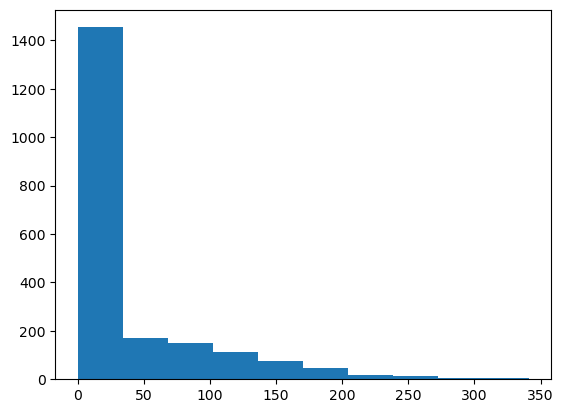

In [22]:
articles['dist'] = articles.progress_apply(lambda row: Levenshtein.distance(row['sentence'], row['extr_span']), axis=1)
plt.hist(articles['dist']);

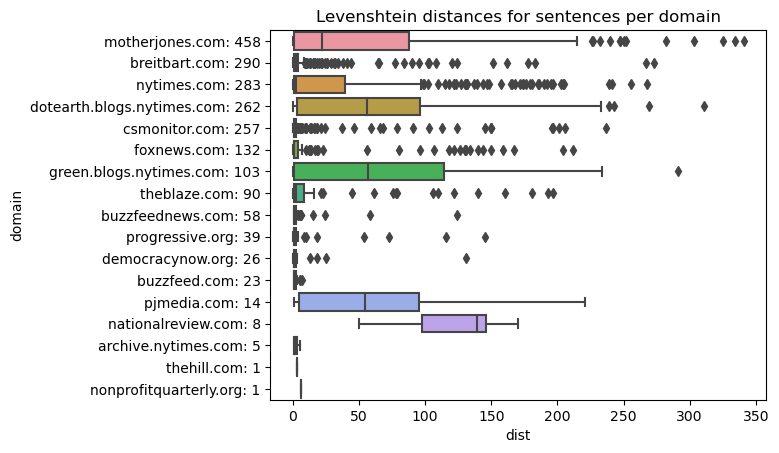

In [80]:
ax = sns.boxplot(data=articles,
                 x='dist',
                 y='domain',
                 order=articles['domain'].value_counts().index,
                 orient='h')
ax.set_yticklabels([str(txt[0])+': '+str(txt[1]) for txt in zip(articles['domain'].value_counts().index, articles['domain'].value_counts().values)])
plt.title("Levenshtein distances for sentences per domain")
plt.show()

##### Troubleshooting: Display un-matched samples

PROBLEMATIC ARTICLES

- text not found on website (not actionable⛔): 59, 118, 145, 
- text not contained in 'body_sents': 8, 
- typo in GWSD-sentence (noun is doubled): 15, 149, 183, 
- manually edited in GWSD to remove 'they say', 'study suggests', or 'that': 29, 48, 56, 114, 181, 
- text not located in 'body_sents': 76, 129
- sentence split incorrect (thus sentence not found): 120,


Conclusions / TODO:
- using a fixed window size does not work...
- process my sentences just like was done by the GWSD; 

In [112]:
for i, row in articles[articles['dist'] > 6].iterrows():
    print(f"[{i}]  dist: {row['dist']}")
    print(f"URL: {row['url_key']}")
    print(f"Query:     {row['sentence']}")
    print(f"Extracted: {row['extr_span']}\n")

[8]  dist: 32
URL: https://www.breitbart.com/politics/2014/07/10/dr-roy-spencer-science-knows-almost-nothing-about-global-warming/
Query:     Claims of global warming have been greatly exaggerated.
Extracted: orking on global warming for the last 20 plus years, wh

[15]  dist: 19
URL: https://foxnews.com/science/arbitrary-adjustments-exaggerate-sea-level-rise-study-finds
Query:     Some parts of the world the world, such as the coast of California, saw sea levels fall.
Extracted: otes that some parts of the world, such as the coast of California, saw sea levels fall.

[29]  dist: 18
URL: https://www.breitbart.com/politics/2017/07/07/40-percent-americans-global-warming-cause-human-extinction/
Query:     Four in ten Americans (40%) have personally experienced the effects of global warming.
Extracted: Four in ten Americans (40%) say they have personally experienced the effects of global

[48]  dist: 23
URL: https://foxnews.com/science/ancient-antarctic-ice-sheet-collapse-could-cause-a-glo

### Select suitable samples
Select which samples are suitable for use in the model. Samples are unsuitable if...
* sentence not identified in source article
* sentence is manually changed from source article to have different meaning

In [157]:
def verify_sample(idx_sent_in_body_sents: int) -> int:
    """Verify the sample by checking if sentence index is present"""
    if idx_sent_in_body_sents == -1:
        return 0
    else:
        return 1
articles['ok'] = articles.apply(lambda row: verify_sample(row['idx_sent_in_body_sents']), axis=1)

In [158]:
# manual correction of unusable samples

incorrect_idx = [
    
]

articles.loc[incorrect_idx, 'ok'] = 0

### Collecting surrounding sentences

In [159]:
def get_surround_sent(ok: int, idx_sent_in_body_sents: int, body_sents: list, offset: int) -> str:
    """Retrieve surrounding sentence by index. If sentence outside range, return empty string."""
    
    if ok != 1:
        return ''
    
    index = idx_sent_in_body_sents + offset
    
    if 0 <= index < len(body_sents): # check if index is in range of body_sents
        return body_sents[index]
    else: # if not, return nothing
        return ''    

for pos in ['-5', '-4', '-3', '-2', '-1', '0', '+1', '+2', '+3', '+4', '+5']:
    articles[f"sent{pos}"] = articles.apply(lambda row: get_surround_sent(row['ok'], row['idx_sent_in_body_sents'], row['body_sents'], int(pos)), axis=1)

In [37]:
articles['extr_sentence'] == articles['sent0']

# this shows that one of these columns is redundant

5       True
6       True
7       True
8       True
9       True
        ... 
2295    True
2296    True
2297    True
2298    True
2299    True
Length: 2050, dtype: bool

### Add label weights (like Luo et al.)

Luo et al. compare a weighted and unweighted model. The weighted data contains the probability float of the highest probability label per sample. The training data also includes the probability for each label, but I am not sure whether that is used during training. I will check that out. 

In [26]:
print('disagree  agree     neutral')
for i, row in articles.iterrows():

    for label in ['disagree', 'agree', 'neutral']:
        print(f"{row[label]:.2f}      ", end='')
    print()

disagree  agree     neutral
0.00      0.71      0.29      
0.00      0.00      1.00      
0.00      0.00      1.00      
1.00      0.00      0.00      
0.03      0.00      0.97      
0.54      0.06      0.40      
0.71      0.00      0.28      
0.00      0.97      0.02      
0.05      0.39      0.56      
0.20      0.48      0.32      
0.00      0.00      1.00      
0.00      0.34      0.66      
0.98      0.00      0.02      
0.00      0.87      0.13      
0.00      0.04      0.96      
0.00      0.51      0.48      
0.00      1.00      0.00      
0.00      0.97      0.02      
0.00      0.75      0.25      
0.00      1.00      0.00      
1.00      0.00      0.00      
0.00      0.31      0.69      
0.00      0.00      1.00      
0.10      0.00      0.89      
0.00      0.12      0.88      
0.04      0.00      0.96      
0.00      0.89      0.10      
0.87      0.00      0.13      
0.98      0.00      0.02      
0.00      0.86      0.13      
0.00      0.41      0.59      
0.00      0